Some preprocessing for Ctrl data from AD-vs-Ctrl dataset

In [1]:
RUN_PYTHON_SCRIPT = False

False

In [2]:
import sys
sys.path.append("../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT

In [3]:
import numpy as np
import scipy
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
from tqdm import trange, tqdm
import time
from joblib import Parallel, delayed

if not RUN_PYTHON_SCRIPT:
    plt.style.use(FIG_ROOT/"base.mplstyle")

In [4]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [5]:
from spectrome import Brain
from sgm.sgm import SGM
from utils.misc import save_pkl, save_pkl_dict2folder, load_pkl, load_pkl_folder2dict, delta_time
from utils.standardize import std_mat, std_vec
from utils.mysignals import wavelet_spectrogram

In [6]:
# pkgs for pytorch ( Mar 27, 2023) 
import torch
import torch.nn as nn
from torch.functional import F
from torch.optim.lr_scheduler import ExponentialLR

torch.set_default_dtype(torch.float64)
if torch.cuda.is_available():
    torch.cuda.set_device(2)
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)
    torch.backends.cudnn.benchmark = True
else:
    torch.set_default_tensor_type(torch.DoubleTensor)

# Get the spectrogram 


In [7]:
from scipy.io import loadmat
from scipy import signal
root = DATA_ROOT/"AD_vs_Ctrl_ts"

_paras = edict()
_paras.freq_limit = [2, 45]
_paras.fs = 600
_paras.fil_path = root/"Ctrl92_all.pkl"
all_meg_ts = load_pkl(_paras.fil_path);

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/Ctrl92_all.pkl


## Using spectrogram in scipy


In [9]:
from scipy import signal
def _conv_signal(spectrogram):
    """
    Apply a low-pass filter to the input spectrogram.

    Args:
        spectrogram (numpy.ndarray): The input spectrogram with shape (n_roi, n_freq, n_t).

    Returns:
        numpy.ndarray: The filtered spectrogram with the same shape as the input.
    """
    lpf = np.array([1, 2, 5, 2, 1])
    lpf = lpf/np.sum(lpf)
    n_roi, _, n_t = spectrogram.shape
    spectrogram_conv = np.zeros_like(spectrogram)
    for t_ix in range(n_t):
        for roi_ix in range(n_roi):
            vec = spectrogram[roi_ix, :, t_ix]
            spectrogram_conv[roi_ix, :, t_ix]= signal.convolve(vec, lpf, mode='same')
    return spectrogram_conv

def preprocessing(data, bds=None, fs=None):
    """Preprocessing MEG data
    args:
        data: meg data, num rois x num pts
        bds: the bands limits to filter
        fs: the sampling freq
    """
    data = signal.detrend(data);
    if fs is not None:
        sos = signal.butter(N=5, Wn=bds, 
                            btype="band", 
                            fs=fs, 
                            output="sos")
        data = signal.sosfilt(sos, data, axis=1);
    return data

In [9]:
spg_paras = edict()
spg_paras.nperseg = 600
spg_paras.noverlap = 300

### Check sample results

In [10]:
# change the file to estimate PSD
sub_ix = 0

MEG_ts = all_meg_ts[sub_ix]
PSD_data = edict()
PSD_data.spectrogram = []
PSD_data.freqs = None
PSD_data.times = None
PSD_data.paras = spg_paras
PSD_data.readme = """The spectrogram is estimated with signal.spectrogram with paras. 
                     Note that it is in |mag|^2 (not in dB)"""
MEG_ts = preprocessing(MEG_ts, bds=_paras.freq_limit, fs=_paras.fs)
freqs, times, Sxx = signal.spectrogram(MEG_ts, _paras.fs, mode="psd", detrend="linear", 
                                       window="hann", 
                                       nperseg=spg_paras.nperseg, 
                                       noverlap=spg_paras.noverlap)
keep_idxs = np.bitwise_and(freqs>=_paras.freq_limit[0],  freqs<=_paras.freq_limit[1])
freqs = freqs[keep_idxs]
Sxx = Sxx[:, keep_idxs]
    
PSD_data.freqs = freqs
PSD_data.times = times
PSD_data.spectrogram = Sxx
PSD_data.spectrogram = _conv_signal(Sxx)

#save_pkl(root/(fil_path.stem + "_spectrogram.pkl"), PSD_data, is_force=True)

Text(0.5, 1.0, 'PSD for each time pt')

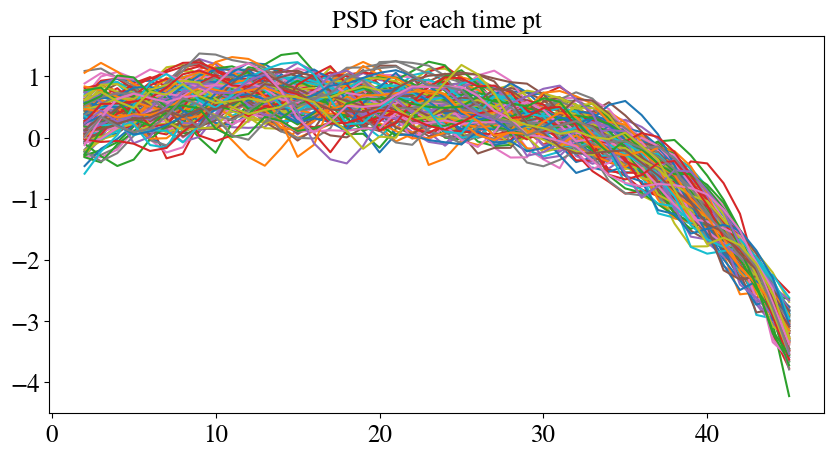

In [11]:
mat = np.log10(PSD_data.spectrogram[0, :, :]);
std_mat = (mat - mat.mean(axis=0, keepdims=1))/mat.std(axis=0, keepdims=1);

#for t_ix in range(10, 20):
for t_ix in range(std_mat.shape[1]):
    plt.plot(freqs, std_mat[:, t_ix])
#t_ix =1
#plt.plot(std_mat[:, t_ix])
plt.title("PSD for each time pt")

In [12]:
std_mat.shape

(44, 119)

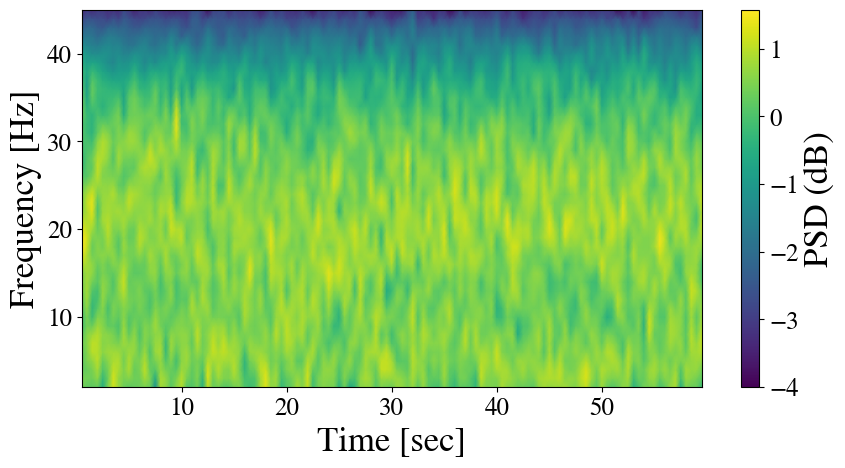

In [14]:
mat = np.log10(PSD_data.spectrogram[1, :, :]);
std_mat = (mat - mat.mean(axis=0, keepdims=1))/mat.std(axis=0, keepdims=1);

#plt.plot(freqs, std_mat.std(axis=-1))
#plt.xlabel('Frequency [Hz]')
#for freq_ix in range(std_mat.shape[0]):
#    plt.plot(times, std_mat[freq_ix])
plt.pcolormesh(times, freqs, std_mat, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='PSD (dB)')
plt.show()

### Run all data and save it

In [15]:
# change the file to estimate PSD
sub_ix = 0
PSD_datas = []
for sub_ix in trange(all_meg_ts.shape[0]):

    MEG_ts = all_meg_ts[sub_ix]
    PSD_data = edict()
    PSD_data.spectrogram = []
    PSD_data.freqs = None
    PSD_data.times = None
    PSD_data.paras = spg_paras
    PSD_data.readme = """The spectrogram is estimated with signal.spectrogram with paras. 
                         Note that it is in |mag|^2 (not in dB)"""
    MEG_ts = preprocessing(MEG_ts, bds=_paras.freq_limit, fs=_paras.fs)
    freqs, times, Sxx = signal.spectrogram(MEG_ts, _paras.fs, mode="psd", detrend="linear", 
                                           window="hann", 
                                           nperseg=spg_paras.nperseg, 
                                           noverlap=spg_paras.noverlap)
    keep_idxs = np.bitwise_and(freqs>=_paras.freq_limit[0],  freqs<=_paras.freq_limit[1])
    freqs = freqs[keep_idxs]
    Sxx = Sxx[:, keep_idxs]
        
    PSD_data.freqs = freqs
    PSD_data.times = times
    PSD_data.spectrogram = Sxx
    PSD_data.spectrogram = _conv_signal(Sxx)

    PSD_datas.append(PSD_data)
save_pkl(_paras.fil_path.parent/"spectrogram_scipy.pkl", PSD_datas, is_force=True)


100%|████████████████████████████████████████████████████████████████████████████| 92/92 [00:31<00:00,  2.95it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/spectrogram_scipy.pkl


## Using wavelet

Let us not using wavelet for now (on Dec 11, 2023)(on Dec 11, 2023)

- it is bit too stationery.

### Check results

In [10]:
sub_ix = 2

MEG_ts = all_meg_ts[sub_ix]
MEG_ts = preprocessing(MEG_ts)

wave_paras = edict()
wave_paras.w_set = 100

PSD_data = edict()
PSD_data.spectrogram = None
PSD_data.freqs = None
PSD_data.times = None
PSD_data.paras = wave_paras
PSD_data.readme = """The spectrogram is estimated with wavelet_spectrogram with paras. 
                     Note that it is in |mag|^2 (not in dB)"""

roi_ix = 0
spectrogram = []
for roi_ix in trange(MEG_ts.shape[0]):
    freqs, times, psds = wavelet_spectrogram(MEG_ts[roi_ix], _paras.fs, wave_paras.w_set);
    spectrogram.append(psds)
    
PSD_data.freqs = freqs
PSD_data.times = times
PSD_data.spectrogram = np.array(spectrogram);

100%|████████████████████████████████████████████████████████████████████████████| 68/68 [00:07<00:00,  8.73it/s]


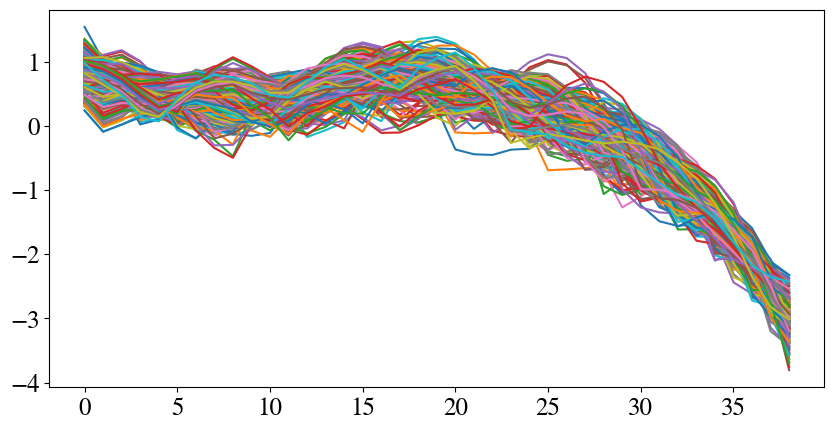

In [11]:
mat = np.log10(PSD_data.spectrogram[2, :, :]);
std_mat = (mat - mat.mean(axis=0, keepdims=1))/mat.std(axis=0, keepdims=1);

#for t_ix in range(10, 20):
for t_ix in range(std_mat.shape[1]):
    plt.plot(std_mat[:, t_ix])
#t_ix =50
#plt.plot(std_mat[:, t_ix])

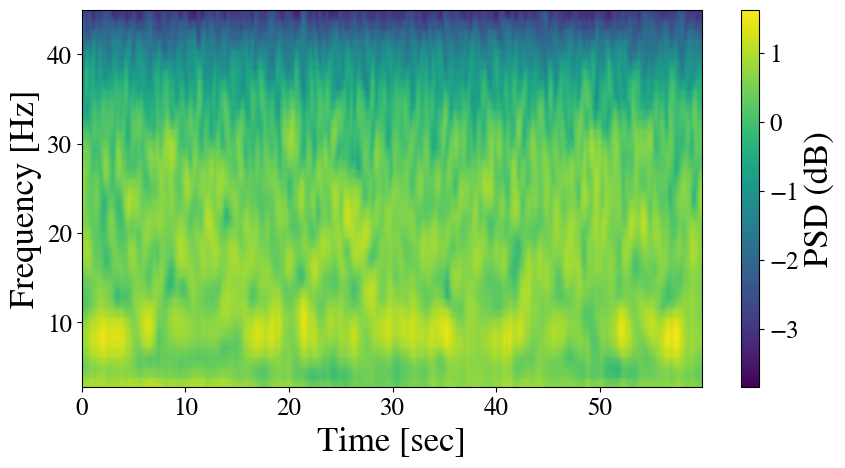

In [54]:
mat = np.log10(PSD_data.spectrogram[0, :, :]);
std_mat = (mat - mat.mean(axis=0, keepdims=1))/mat.std(axis=0, keepdims=1);

plt.pcolormesh(times, freqs, std_mat, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='PSD (dB)')
plt.show()

### Run and save results

In [12]:
sub_ix = 2
def _run_fn(sub_ix):
    MEG_ts = all_meg_ts[sub_ix]
    MEG_ts = preprocessing(MEG_ts)
    
    wave_paras = edict()
    wave_paras.w_set = 100
    
    PSD_data = edict()
    PSD_data.spectrogram = None
    PSD_data.freqs = None
    PSD_data.times = None
    PSD_data.paras = wave_paras
    PSD_data.readme = """The spectrogram is estimated with wavelet_spectrogram with paras. 
                         Note that it is in |mag|^2 (not in dB)"""
    
    roi_ix = 0
    spectrogram = []
    for roi_ix in range(MEG_ts.shape[0]):
        freqs, times, psds = wavelet_spectrogram(MEG_ts[roi_ix], _paras.fs, wave_paras.w_set);
        spectrogram.append(psds)
        
    PSD_data.freqs = freqs
    PSD_data.times = times
    PSD_data.spectrogram = np.array(spectrogram);
    return PSD_data

with Parallel(n_jobs=20) as parallel:
    PSD_datas = parallel(delayed(_run_fn)(sub_ix) for sub_ix in tqdm(range(92), total=92))
save_pkl(_paras.fil_path.parent/f"spectrogram_wavelet{wave_paras.w_set}.pkl", PSD_datas, is_force=True)

100%|████████████████████████████████████████████████████████████████████████████| 92/92 [01:11<00:00,  1.29it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/spectrogram_wavelet100.pkl


# produce base metrics

In [54]:
from models.loss import reg_R_fn, lin_R_fn
typ = "scipy" # scipy or wavelet

'scipy'

In [55]:
# get order idx
# idx from 36-MEG order to Ctrl-data order
# org_order: ctrl data order
# target_order: SGMnet order, SC order
org_order = np.loadtxt(DATA_ROOT/"AD_vs_Ctrl_ts/roi_order.txt", dtype=str);
target_order0 = np.loadtxt(DATA_ROOT/"DK_atlas_36MEG.txt", dtype=str);
target_order = np.array([f"ctx-{roi_name.split('_')[1].lower()}h-{roi_name.split('_')[0].lower()}" for roi_name in target_order0[:68]]);
org2target_idxs = np.array([np.where(org_order==roi)[0][0] for roi in target_order]);
(org_order[org2target_idxs] == target_order).mean()

psd_all_full0 = load_pkl(DATA_ROOT/f"AD_vs_Ctrl_ts/spectrogram_{typ}.pkl");

psd_all_full = np.array([res["spectrogram"] for res in psd_all_full0]);
psd_all_full = 10 * np.log10(psd_all_full) # to dB scale
# make the ctrl data order is compatible to SGM net 
psd_all_full = psd_all_full[:, org2target_idxs]
time_points = psd_all_full0[0]["times"]
freqs = psd_all_full0[0]["freqs"];

# num_sub x n_pts x n_rois x n_freqs
all_data = psd_all_full.transpose(0, 3, 1, 2);
all_data_std = (all_data - all_data.mean(axis=-1, keepdims=True))/all_data.std(axis=-1, keepdims=True);

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/spectrogram_scipy.pkl


<AxesSubplot:>

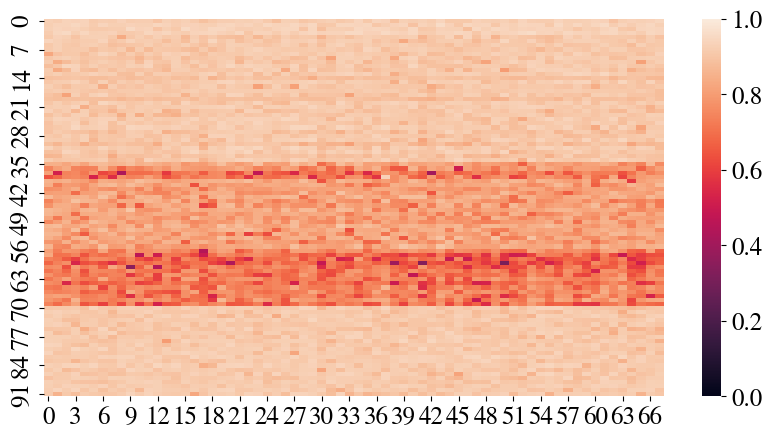

In [63]:
all_corrs = []
for sub_ix in range(92):
    cor_seq = []
    for roi_ix in range(68):
        corrmat = np.corrcoef(all_data_std[sub_ix, :, roi_ix])
        cor_seq.append(corrmat[100, :].mean())
        #cor_seq.append(np.diag(corrmat, 1).mean())
        #cor_seq.append(corrmat[np.triu_indices_from(corrmat, 1)].mean())
    all_corrs.append(cor_seq)
all_corrs = np.array(all_corrs);    
sns.heatmap(all_corrs, vmin=0, vmax=1)

In [22]:
# the simulated data
if typ.lower().startswith("scipy"):
    simu_sgm_data = load_pkl_folder2dict(RES_ROOT/"simu_sgm_data_ind_eye_close", including=["PSDs_test"]);
elif typ.lower().startswith("wave"):
    simu_sgm_data = load_pkl_folder2dict(RES_ROOT/"simu_sgm_data_ind_large", including=["PSDs_test"]);

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_sgm_data_ind_large/PSDs_test.pkl


In [23]:
base_PSDs_dB = 20*np.log10(simu_sgm_data.PSDs_test[:1000]);
base_PSDs_dB_std = (base_PSDs_dB - base_PSDs_dB.mean(axis=-1, keepdims=True))/base_PSDs_dB.std(axis=-1, keepdims=True);

In [24]:
# path to save
target_path = DATA_ROOT/"AD_vs_Ctrl_ts"/f"ctrl_{typ}_base_1000"
if not target_path.exists():
    target_path.mkdir()

In [25]:
def _all2stat_fn(corrs):
    """output useful stats for the base corrs
    """
    res = edict()
    if corrs.ndim == 1:
        res.mean = np.mean(corrs)
        res.median = np.median(corrs)
        res.std = np.std(corrs)
    elif corrs.ndim == 2:
        assert corrs.shape[-1] == 68
        res.mean = np.mean(corrs, axis=0)
        res.median = np.median(corrs, axis=0)
        res.std = np.std(corrs, axis=0)
    return res

## Reg R

In [26]:
for sub_ix in trange(all_data_std.shape[0]):
    cur_sub_corrs = []
    cur_sub_corrs_roiwise = []
    for time_ix in range(all_data_std.shape[1]):
        cur_data = all_data_std[sub_ix, time_ix];
        cur_data_rep = np.repeat(cur_data[np.newaxis], len(base_PSDs_dB_std), axis=0)
        base_corrs_roiwise  = reg_R_fn(base_PSDs_dB_std, cur_data_rep)
        base_corrs = reg_R_fn(base_PSDs_dB_std.mean(axis=1), 
                              cur_data_rep.mean(axis=1))
        cur_sub_corrs_roiwise.append(_all2stat_fn(base_corrs_roiwise))
        cur_sub_corrs.append(_all2stat_fn(base_corrs))
        
    save_pkl(target_path/f"regR_{sub_ix}.pkl", cur_sub_corrs)
    save_pkl(target_path/f"regR_roiwise_{sub_ix}.pkl", cur_sub_corrs_roiwise)

  1%|▊                                                                            | 1/92 [00:13<20:23, 13.45s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_0.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_0.pkl


  2%|█▋                                                                           | 2/92 [00:26<20:09, 13.44s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_1.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_1.pkl


  3%|██▌                                                                          | 3/92 [00:40<19:55, 13.43s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_2.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_2.pkl


  4%|███▎                                                                         | 4/92 [00:53<19:42, 13.44s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_3.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_3.pkl


  5%|████▏                                                                        | 5/92 [01:07<19:28, 13.43s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_4.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_4.pkl


  7%|█████                                                                        | 6/92 [01:20<19:14, 13.43s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_5.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_5.pkl


  8%|█████▊                                                                       | 7/92 [01:33<19:00, 13.42s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_6.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_6.pkl


  9%|██████▋                                                                      | 8/92 [01:47<18:47, 13.42s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_7.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_7.pkl


 10%|███████▌                                                                     | 9/92 [02:01<18:40, 13.50s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_8.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_8.pkl


 11%|████████▎                                                                   | 10/92 [02:15<18:39, 13.65s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_9.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_9.pkl


 12%|█████████                                                                   | 11/92 [02:28<18:30, 13.71s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_10.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_10.pkl


 13%|█████████▉                                                                  | 12/92 [02:42<18:21, 13.77s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_11.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_11.pkl


 14%|██████████▋                                                                 | 13/92 [02:56<18:10, 13.81s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_12.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_12.pkl


 15%|███████████▌                                                                | 14/92 [03:10<17:59, 13.84s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_13.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_13.pkl


 16%|████████████▍                                                               | 15/92 [03:24<17:49, 13.89s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_14.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_14.pkl


 17%|█████████████▏                                                              | 16/92 [03:38<17:35, 13.89s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_15.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_15.pkl


 18%|██████████████                                                              | 17/92 [03:52<17:22, 13.90s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_16.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_16.pkl


 20%|██████████████▊                                                             | 18/92 [04:06<17:09, 13.91s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_17.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_17.pkl


 21%|███████████████▋                                                            | 19/92 [04:20<16:56, 13.92s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_18.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_18.pkl


 22%|████████████████▌                                                           | 20/92 [04:34<16:42, 13.92s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_19.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_19.pkl


 23%|█████████████████▎                                                          | 21/92 [04:48<16:25, 13.88s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_20.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_20.pkl


 24%|██████████████████▏                                                         | 22/92 [05:01<16:10, 13.87s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_21.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_21.pkl


 25%|███████████████████                                                         | 23/92 [05:15<15:55, 13.85s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_22.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_22.pkl


 26%|███████████████████▊                                                        | 24/92 [05:29<15:41, 13.85s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_23.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_23.pkl


 27%|████████████████████▋                                                       | 25/92 [05:43<15:28, 13.85s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_24.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_24.pkl


 28%|█████████████████████▍                                                      | 26/92 [05:57<15:13, 13.84s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_25.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_25.pkl


 29%|██████████████████████▎                                                     | 27/92 [06:11<14:59, 13.84s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_26.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_26.pkl


 30%|███████████████████████▏                                                    | 28/92 [06:24<14:45, 13.83s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_27.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_27.pkl


 32%|███████████████████████▉                                                    | 29/92 [06:38<14:31, 13.84s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_28.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_28.pkl


 33%|████████████████████████▊                                                   | 30/92 [06:52<14:17, 13.83s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_29.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_29.pkl


 34%|█████████████████████████▌                                                  | 31/92 [07:06<14:03, 13.83s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_30.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_30.pkl


 35%|██████████████████████████▍                                                 | 32/92 [07:20<13:49, 13.82s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_31.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_31.pkl


 36%|███████████████████████████▎                                                | 33/92 [07:33<13:35, 13.82s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_32.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_32.pkl


 37%|████████████████████████████                                                | 34/92 [07:47<13:21, 13.82s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_33.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_33.pkl


 38%|████████████████████████████▉                                               | 35/92 [08:01<13:08, 13.82s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_34.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_34.pkl


 39%|█████████████████████████████▋                                              | 36/92 [08:15<12:55, 13.84s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_35.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_35.pkl


 40%|██████████████████████████████▌                                             | 37/92 [08:29<12:41, 13.84s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_36.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_36.pkl


 41%|███████████████████████████████▍                                            | 38/92 [08:43<12:27, 13.84s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_37.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_37.pkl


 42%|████████████████████████████████▏                                           | 39/92 [08:57<12:14, 13.87s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_38.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_38.pkl


 43%|█████████████████████████████████                                           | 40/92 [09:10<12:00, 13.86s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_39.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_39.pkl


 45%|█████████████████████████████████▊                                          | 41/92 [09:24<11:46, 13.84s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_40.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_40.pkl


 46%|██████████████████████████████████▋                                         | 42/92 [09:38<11:31, 13.84s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_41.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_41.pkl


 47%|███████████████████████████████████▌                                        | 43/92 [09:52<11:17, 13.84s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_42.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_42.pkl


 48%|████████████████████████████████████▎                                       | 44/92 [10:06<11:04, 13.84s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_43.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_43.pkl


 49%|█████████████████████████████████████▏                                      | 45/92 [10:20<10:50, 13.83s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_44.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_44.pkl


 50%|██████████████████████████████████████                                      | 46/92 [10:33<10:35, 13.82s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_45.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_45.pkl


 51%|██████████████████████████████████████▊                                     | 47/92 [10:47<10:22, 13.82s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_46.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_46.pkl


 52%|███████████████████████████████████████▋                                    | 48/92 [11:01<10:09, 13.85s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_47.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_47.pkl


 53%|████████████████████████████████████████▍                                   | 49/92 [11:15<09:54, 13.83s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_48.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_48.pkl


 54%|█████████████████████████████████████████▎                                  | 50/92 [11:29<09:40, 13.82s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_49.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_49.pkl


 55%|██████████████████████████████████████████▏                                 | 51/92 [11:42<09:26, 13.81s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_50.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_50.pkl


 57%|██████████████████████████████████████████▉                                 | 52/92 [11:56<09:12, 13.80s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_51.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_51.pkl


 58%|███████████████████████████████████████████▊                                | 53/92 [12:10<08:58, 13.80s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_52.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_52.pkl


 59%|████████████████████████████████████████████▌                               | 54/92 [12:24<08:44, 13.79s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_53.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_53.pkl


 60%|█████████████████████████████████████████████▍                              | 55/92 [12:38<08:30, 13.79s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_54.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_54.pkl


 61%|██████████████████████████████████████████████▎                             | 56/92 [12:51<08:16, 13.79s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_55.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_55.pkl


 62%|███████████████████████████████████████████████                             | 57/92 [13:05<08:02, 13.78s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_56.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_56.pkl


 63%|███████████████████████████████████████████████▉                            | 58/92 [13:19<07:48, 13.78s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_57.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_57.pkl


 64%|████████████████████████████████████████████████▋                           | 59/92 [13:33<07:34, 13.78s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_58.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_58.pkl


 65%|█████████████████████████████████████████████████▌                          | 60/92 [13:46<07:20, 13.76s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_59.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_59.pkl


 66%|██████████████████████████████████████████████████▍                         | 61/92 [14:00<07:06, 13.75s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_60.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_60.pkl


 67%|███████████████████████████████████████████████████▏                        | 62/92 [14:14<06:52, 13.75s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_61.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_61.pkl


 68%|████████████████████████████████████████████████████                        | 63/92 [14:28<06:38, 13.75s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_62.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_62.pkl


 70%|████████████████████████████████████████████████████▊                       | 64/92 [14:41<06:24, 13.73s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_63.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_63.pkl


 71%|█████████████████████████████████████████████████████▋                      | 65/92 [14:55<06:08, 13.63s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_64.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_64.pkl


 72%|██████████████████████████████████████████████████████▌                     | 66/92 [15:08<05:52, 13.57s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_65.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_65.pkl


 73%|███████████████████████████████████████████████████████▎                    | 67/92 [15:22<05:38, 13.52s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_66.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_66.pkl


 74%|████████████████████████████████████████████████████████▏                   | 68/92 [15:35<05:24, 13.53s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_67.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_67.pkl


 75%|█████████████████████████████████████████████████████████                   | 69/92 [15:49<05:11, 13.53s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_68.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_68.pkl


 76%|█████████████████████████████████████████████████████████▊                  | 70/92 [16:02<04:57, 13.53s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_69.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_69.pkl


 77%|██████████████████████████████████████████████████████████▋                 | 71/92 [16:16<04:44, 13.53s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_70.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_70.pkl


 78%|███████████████████████████████████████████████████████████▍                | 72/92 [16:29<04:30, 13.53s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_71.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_71.pkl


 79%|████████████████████████████████████████████████████████████▎               | 73/92 [16:43<04:17, 13.54s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_72.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_72.pkl


 80%|█████████████████████████████████████████████████████████████▏              | 74/92 [16:57<04:04, 13.59s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_73.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_73.pkl


 82%|█████████████████████████████████████████████████████████████▉              | 75/92 [17:10<03:51, 13.62s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_74.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_74.pkl


 83%|██████████████████████████████████████████████████████████████▊             | 76/92 [17:24<03:38, 13.65s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_75.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_75.pkl


 84%|███████████████████████████████████████████████████████████████▌            | 77/92 [17:38<03:25, 13.67s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_76.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_76.pkl


 85%|████████████████████████████████████████████████████████████████▍           | 78/92 [17:51<03:11, 13.69s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_77.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_77.pkl


 86%|█████████████████████████████████████████████████████████████████▎          | 79/92 [18:05<02:58, 13.70s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_78.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_78.pkl


 87%|██████████████████████████████████████████████████████████████████          | 80/92 [18:19<02:44, 13.70s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_79.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_79.pkl


 88%|██████████████████████████████████████████████████████████████████▉         | 81/92 [18:33<02:30, 13.71s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_80.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_80.pkl


 89%|███████████████████████████████████████████████████████████████████▋        | 82/92 [18:46<02:17, 13.71s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_81.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_81.pkl


 90%|████████████████████████████████████████████████████████████████████▌       | 83/92 [19:00<02:03, 13.71s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_82.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_82.pkl


 91%|█████████████████████████████████████████████████████████████████████▍      | 84/92 [19:13<01:48, 13.60s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_83.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_83.pkl


 92%|██████████████████████████████████████████████████████████████████████▏     | 85/92 [19:27<01:34, 13.52s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_84.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_84.pkl


 93%|███████████████████████████████████████████████████████████████████████     | 86/92 [19:40<01:20, 13.47s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_85.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_85.pkl


 95%|███████████████████████████████████████████████████████████████████████▊    | 87/92 [19:53<01:07, 13.42s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_86.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_86.pkl


 96%|████████████████████████████████████████████████████████████████████████▋   | 88/92 [20:07<00:53, 13.40s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_87.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_87.pkl


 97%|█████████████████████████████████████████████████████████████████████████▌  | 89/92 [20:20<00:40, 13.38s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_88.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_88.pkl


 98%|██████████████████████████████████████████████████████████████████████████▎ | 90/92 [20:33<00:26, 13.36s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_89.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_89.pkl


 99%|███████████████████████████████████████████████████████████████████████████▏| 91/92 [20:47<00:13, 13.35s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_90.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_90.pkl


100%|████████████████████████████████████████████████████████████████████████████| 92/92 [21:00<00:00, 13.70s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_91.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/regR_roiwise_91.pkl


## linR

In [27]:
for sub_ix in trange(all_data_std.shape[0]):
    cur_sub_corrs = []
    cur_sub_corrs_roiwise = []
    for time_ix in range(all_data_std.shape[1]):
        cur_data = all_data_std[sub_ix, time_ix];
        cur_data_rep = np.repeat(cur_data[np.newaxis], len(base_PSDs_dB_std), axis=0)
        base_corrs_roiwise  = lin_R_fn(base_PSDs_dB_std, cur_data_rep)
        base_corrs = lin_R_fn(base_PSDs_dB_std.mean(axis=1), 
                              cur_data_rep.mean(axis=1))
        cur_sub_corrs_roiwise.append(_all2stat_fn(base_corrs_roiwise))
        cur_sub_corrs.append(_all2stat_fn(base_corrs))
        
    save_pkl(target_path/f"linR_{sub_ix}.pkl", cur_sub_corrs)
    save_pkl(target_path/f"linR_roiwise_{sub_ix}.pkl", cur_sub_corrs_roiwise)

  1%|▊                                                                            | 1/92 [00:11<17:44, 11.70s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_0.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_0.pkl


  2%|█▋                                                                           | 2/92 [00:23<17:33, 11.70s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_1.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_1.pkl


  3%|██▌                                                                          | 3/92 [00:35<17:20, 11.69s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_2.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_2.pkl


  4%|███▎                                                                         | 4/92 [00:46<17:09, 11.70s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_3.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_3.pkl


  5%|████▏                                                                        | 5/92 [00:58<16:57, 11.70s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_4.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_4.pkl


  7%|█████                                                                        | 6/92 [01:10<16:49, 11.74s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_5.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_5.pkl


  8%|█████▊                                                                       | 7/92 [01:22<16:41, 11.78s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_6.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_6.pkl


  9%|██████▋                                                                      | 8/92 [01:34<16:31, 11.80s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_7.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_7.pkl


 10%|███████▌                                                                     | 9/92 [01:45<16:20, 11.82s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_8.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_8.pkl


 11%|████████▎                                                                   | 10/92 [01:57<16:09, 11.83s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_9.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_9.pkl


 12%|█████████                                                                   | 11/92 [02:09<15:58, 11.84s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_10.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_10.pkl


 13%|█████████▉                                                                  | 12/92 [02:21<15:44, 11.80s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_11.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_11.pkl


 14%|██████████▋                                                                 | 13/92 [02:33<15:30, 11.78s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_12.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_12.pkl


 15%|███████████▌                                                                | 14/92 [02:44<15:17, 11.76s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_13.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_13.pkl


 16%|████████████▍                                                               | 15/92 [02:56<15:04, 11.75s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_14.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_14.pkl


 17%|█████████████▏                                                              | 16/92 [03:08<14:52, 11.74s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_15.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_15.pkl


 18%|██████████████                                                              | 17/92 [03:19<14:39, 11.73s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_16.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_16.pkl


 20%|██████████████▊                                                             | 18/92 [03:31<14:27, 11.73s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_17.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_17.pkl


 21%|███████████████▋                                                            | 19/92 [03:43<14:16, 11.73s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_18.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_18.pkl


 22%|████████████████▌                                                           | 20/92 [03:55<14:04, 11.72s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_19.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_19.pkl


 23%|█████████████████▎                                                          | 21/92 [04:06<13:52, 11.72s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_20.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_20.pkl


 24%|██████████████████▏                                                         | 22/92 [04:18<13:40, 11.72s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_21.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_21.pkl


 25%|███████████████████                                                         | 23/92 [04:30<13:28, 11.72s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_22.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_22.pkl


 26%|███████████████████▊                                                        | 24/92 [04:42<13:19, 11.75s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_23.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_23.pkl


 27%|████████████████████▋                                                       | 25/92 [04:53<13:06, 11.74s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_24.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_24.pkl


 28%|█████████████████████▍                                                      | 26/92 [05:05<12:54, 11.74s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_25.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_25.pkl


 29%|██████████████████████▎                                                     | 27/92 [05:17<12:42, 11.73s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_26.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_26.pkl


 30%|███████████████████████▏                                                    | 28/92 [05:28<12:30, 11.73s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_27.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_27.pkl


 32%|███████████████████████▉                                                    | 29/92 [05:40<12:18, 11.72s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_28.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_28.pkl


 33%|████████████████████████▊                                                   | 30/92 [05:52<12:06, 11.72s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_29.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_29.pkl


 34%|█████████████████████████▌                                                  | 31/92 [06:04<11:54, 11.72s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_30.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_30.pkl


 35%|██████████████████████████▍                                                 | 32/92 [06:15<11:43, 11.72s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_31.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_31.pkl


 36%|███████████████████████████▎                                                | 33/92 [06:27<11:31, 11.72s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_32.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_32.pkl


 37%|████████████████████████████                                                | 34/92 [06:39<11:20, 11.73s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_33.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_33.pkl


 38%|████████████████████████████▉                                               | 35/92 [06:50<11:08, 11.73s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_34.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_34.pkl


 39%|█████████████████████████████▋                                              | 36/92 [07:02<10:56, 11.73s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_35.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_35.pkl


 40%|██████████████████████████████▌                                             | 37/92 [07:14<10:44, 11.72s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_36.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_36.pkl


 41%|███████████████████████████████▍                                            | 38/92 [07:26<10:32, 11.72s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_37.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_37.pkl


 42%|████████████████████████████████▏                                           | 39/92 [07:37<10:21, 11.72s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_38.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_38.pkl


 43%|█████████████████████████████████                                           | 40/92 [07:49<10:09, 11.72s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_39.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_39.pkl


 45%|█████████████████████████████████▊                                          | 41/92 [08:01<09:57, 11.72s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_40.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_40.pkl


 46%|██████████████████████████████████▋                                         | 42/92 [08:13<09:46, 11.72s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_41.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_41.pkl


 47%|███████████████████████████████████▌                                        | 43/92 [08:24<09:34, 11.72s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_42.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_42.pkl


 48%|████████████████████████████████████▎                                       | 44/92 [08:36<09:22, 11.72s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_43.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_43.pkl


 49%|█████████████████████████████████████▏                                      | 45/92 [08:48<09:10, 11.72s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_44.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_44.pkl


 50%|██████████████████████████████████████                                      | 46/92 [08:59<08:58, 11.72s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_45.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_45.pkl


 51%|██████████████████████████████████████▊                                     | 47/92 [09:11<08:47, 11.71s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_46.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_46.pkl


 52%|███████████████████████████████████████▋                                    | 48/92 [09:23<08:35, 11.72s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_47.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_47.pkl


 53%|████████████████████████████████████████▍                                   | 49/92 [09:35<08:23, 11.72s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_48.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_48.pkl


 54%|█████████████████████████████████████████▎                                  | 50/92 [09:46<08:12, 11.73s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_49.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_49.pkl


 55%|██████████████████████████████████████████▏                                 | 51/92 [09:58<08:01, 11.74s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_50.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_50.pkl


 57%|██████████████████████████████████████████▉                                 | 52/92 [10:10<07:49, 11.74s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_51.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_51.pkl


 58%|███████████████████████████████████████████▊                                | 53/92 [10:22<07:37, 11.74s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_52.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_52.pkl


 59%|████████████████████████████████████████████▌                               | 54/92 [10:33<07:25, 11.74s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_53.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_53.pkl


 60%|█████████████████████████████████████████████▍                              | 55/92 [10:45<07:15, 11.77s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_54.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_54.pkl


 61%|██████████████████████████████████████████████▎                             | 56/92 [10:57<07:05, 11.81s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_55.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_55.pkl


 62%|███████████████████████████████████████████████                             | 57/92 [11:09<06:54, 11.83s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_56.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_56.pkl


 63%|███████████████████████████████████████████████▉                            | 58/92 [11:21<06:43, 11.86s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_57.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_57.pkl


 64%|████████████████████████████████████████████████▋                           | 59/92 [11:33<06:31, 11.86s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_58.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_58.pkl


 65%|█████████████████████████████████████████████████▌                          | 60/92 [11:45<06:19, 11.86s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_59.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_59.pkl


 66%|██████████████████████████████████████████████████▍                         | 61/92 [11:56<06:07, 11.87s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_60.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_60.pkl


 67%|███████████████████████████████████████████████████▏                        | 62/92 [12:08<05:56, 11.88s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_61.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_61.pkl


 68%|████████████████████████████████████████████████████                        | 63/92 [12:20<05:43, 11.83s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_62.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_62.pkl


 70%|████████████████████████████████████████████████████▊                       | 64/92 [12:32<05:30, 11.80s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_63.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_63.pkl


 71%|█████████████████████████████████████████████████████▋                      | 65/92 [12:44<05:18, 11.78s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_64.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_64.pkl


 72%|██████████████████████████████████████████████████████▌                     | 66/92 [12:55<05:06, 11.77s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_65.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_65.pkl


 73%|███████████████████████████████████████████████████████▎                    | 67/92 [13:07<04:54, 11.76s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_66.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_66.pkl


 74%|████████████████████████████████████████████████████████▏                   | 68/92 [13:19<04:42, 11.75s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_67.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_67.pkl


 75%|█████████████████████████████████████████████████████████                   | 69/92 [13:30<04:29, 11.74s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_68.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_68.pkl


 76%|█████████████████████████████████████████████████████████▊                  | 70/92 [13:42<04:17, 11.73s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_69.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_69.pkl


 77%|██████████████████████████████████████████████████████████▋                 | 71/92 [13:54<04:06, 11.76s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_70.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_70.pkl


 78%|███████████████████████████████████████████████████████████▍                | 72/92 [14:06<03:55, 11.79s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_71.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_71.pkl


 79%|████████████████████████████████████████████████████████████▎               | 73/92 [14:18<03:44, 11.81s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_72.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_72.pkl


 80%|█████████████████████████████████████████████████████████████▏              | 74/92 [14:30<03:32, 11.83s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_73.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_73.pkl


 82%|█████████████████████████████████████████████████████████████▉              | 75/92 [14:41<03:21, 11.84s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_74.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_74.pkl


 83%|██████████████████████████████████████████████████████████████▊             | 76/92 [14:53<03:09, 11.84s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_75.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_75.pkl


 84%|███████████████████████████████████████████████████████████████▌            | 77/92 [15:05<02:57, 11.85s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_76.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_76.pkl


 85%|████████████████████████████████████████████████████████████████▍           | 78/92 [15:17<02:45, 11.86s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_77.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_77.pkl


 86%|█████████████████████████████████████████████████████████████████▎          | 79/92 [15:29<02:34, 11.86s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_78.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_78.pkl


 87%|██████████████████████████████████████████████████████████████████          | 80/92 [15:41<02:22, 11.86s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_79.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_79.pkl


 88%|██████████████████████████████████████████████████████████████████▉         | 81/92 [15:53<02:10, 11.85s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_80.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_80.pkl


 89%|███████████████████████████████████████████████████████████████████▋        | 82/92 [16:04<01:58, 11.84s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_81.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_81.pkl


 90%|████████████████████████████████████████████████████████████████████▌       | 83/92 [16:16<01:46, 11.85s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_82.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_82.pkl


 91%|█████████████████████████████████████████████████████████████████████▍      | 84/92 [16:28<01:34, 11.87s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_83.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_83.pkl


 92%|██████████████████████████████████████████████████████████████████████▏     | 85/92 [16:40<01:23, 11.86s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_84.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_84.pkl


 93%|███████████████████████████████████████████████████████████████████████     | 86/92 [16:52<01:11, 11.87s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_85.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_85.pkl


 95%|███████████████████████████████████████████████████████████████████████▊    | 87/92 [17:04<00:59, 11.86s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_86.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_86.pkl


 96%|████████████████████████████████████████████████████████████████████████▋   | 88/92 [17:16<00:47, 11.86s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_87.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_87.pkl


 97%|█████████████████████████████████████████████████████████████████████████▌  | 89/92 [17:27<00:35, 11.86s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_88.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_88.pkl


 98%|██████████████████████████████████████████████████████████████████████████▎ | 90/92 [17:39<00:23, 11.86s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_89.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_89.pkl


 99%|███████████████████████████████████████████████████████████████████████████▏| 91/92 [17:51<00:11, 11.87s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_90.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_90.pkl


100%|████████████████████████████████████████████████████████████████████████████| 92/92 [18:03<00:00, 11.78s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_91.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/ctrl_wavelet100_base_1000/linR_roiwise_91.pkl
